In [1]:
import numpy as np
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from numpy import linalg as LA
# from scipy import linalg
from astropy import units as u
from astropy import constants as const

In [32]:
from trajectory_calculation import falling_trajectory

x0 = -500  # R.A.
y0 = -500  # Decl.
z0 = -500  # Radial dist.
vx0 = 0
vy0 = 2
vz0 = 1
Ms_val = 0.251188643150958#*u.solMass

rt,vt,rt_spherical,vt_spherical = falling_trajectory(x0,y0,z0,vx0,vy0,vz0,Ms_val,ang_range = 0.5*np.pi)

Initial coords in rotated cartesian frame: [  0.         866.02540378   0.        ]
Initial coords in spherical frame: [866.02540378   1.57079633   1.57079633]
Can we get back the original coords?: True
Initial vel. in rotated cartesian frame: [-1.41421356 -1.73205081  0.        ]
Initial vel. in spherical frame: [-1.73205081e+00 -1.06057524e-16  1.41421356e+00]
Total energy: 2.2426906366290993 km2 / s2
Orbit eccentricity: 11.683039519045492
Sign of position gradients do not match velocities.


In [35]:
Ms_val = 0.251188643150958#*u.solMass

x0 = -500  # R.A.
y0 = -500  # Decl.
z0 = -500  # Radial dist.
vx0 = 0
vy0 = 2
vz0 = 1

r0_v = np.array([x0,y0,z0])#*u.au
v0_v = np.array([vx0,vy0,vz0])#*u.km/u.s

In [36]:
### Unit vectors of rotated frame
r0_mag = LA.norm(r0_v)
r0_e = r0_v/r0_mag
r0_e

n_v = np.cross(r0_v,v0_v)  #normal to r0_v and v0_v plane
n_mag = LA.norm(n_v)
n_e = n_v/n_mag
# n_e

m_v = np.cross(r0_v,n_v)  #normal to r0_v and v0_v plane
m_mag = LA.norm(m_v)
m_e = m_v/m_mag
# m_e

### Coordinate transformation
trans1 = np.array([m_e,r0_e,n_e])
inv_trans1 = LA.inv(trans1)  # inverse transformation matrix
c1 = r0_v#[1000,-2321,0.01]    # coordinate in original ra, dec, dist..
c2 = np.matmul(trans1,c1)     # coord. in new m, r0, n...
print("Initial coords in rotated cartesian frame:",c2)

r0 = np.sqrt(sum(c2**2))
theta0 = np.arccos(c2[2]/r0)  # should always for pi/2
phi0 = np.arctan2(c2[1],c2[0]) # should be pi/2 for r0
sr0 = np.array([r0, theta0, phi0])
print("Initial coords in spherical frame:",sr0)

# going back to c2 coords
x2f = r0*np.sin(theta0)*np.cos(phi0)
y2f = r0*np.sin(theta0)*np.sin(phi0)
z2f = r0*np.cos(theta0)
c2f = [x2f,y2f,z2f]
# np.isclose(c2,[x2f,y2f,z2f]).all() # should be True
# going back to c1 coords
f = np.matmul(inv_trans1,c2f)
print("Can we get back the original coords?:",np.isclose(f,c1).all()) # should be True

v0_v2 = np.matmul(trans1,v0_v) 
print("Initial vel. in rotated cartesian frame:",v0_v2)
trans2 = np.array([[np.sin(theta0)*np.cos(phi0),np.sin(theta0)*np.sin(phi0),np.cos(theta0)],
                   [np.cos(theta0)*np.cos(phi0),np.cos(theta0)*np.sin(phi0),-np.sin(theta0)],
                   [-np.sin(phi0),np.cos(phi0),0]])
sv0 = np.matmul(trans2,v0_v2)
print("Initial vel. in spherical frame:",sv0)

r0 = r0*u.au  # give units
vr0 = sv0[0]*u.km/u.s  # initial vel. in r
vphi0 = sv0[2]*u.km/u.s   # initial vel. in phi
h0 = vphi0*r0   # initial (conserved) angular momentum w.r.t. azimuth (assuming theta0 = pi/2)

### Calculate total energy and other constants
E = (0.5*(vr0**2)) + (0.5*((h0*np.sin(theta0)/r0)**2)) - (const.G*Ms/r0)  # Eq. 2 in Mendoza+09
print("Total energy:",E)

ru = (h0**2)/(const.G*Ms)
E0 = (const.G*Ms)/ru
vk = np.sqrt(E0)

mu = np.sqrt((ru/r0)**2)  # Eq. 3 in Mendoza+09 (also np.sqrt(((h0/r0)**2)/E0))
nu = np.sqrt((vr0**2)/E0)  # Eq. 3 in Mendoza+09
# mu,nu

epsilon = 2*E/E0
ecc = np.sqrt(1+epsilon*(np.sin(theta0)**2))   ## NEED TO CHECK
print("Orbit eccentricity:",ecc)

Initial coords in rotated cartesian frame: [  0.         866.02540378   0.        ]
Initial coords in spherical frame: [866.02540378   1.57079633   1.57079633]
Can we get back the original coords?: True
Initial vel. in rotated cartesian frame: [-1.41421356 -1.73205081  0.        ]
Initial vel. in spherical frame: [-1.73205081e+00 -1.06057524e-16  1.41421356e+00]
Total energy: -7.74367026085112 km2 / s2
Orbit eccentricity: 0.839532050381567


In [94]:
### Computing trajectory
pang0 = np.arccos((1/ecc)*(1-mu*(np.sin(theta0)**2))).to(u.rad).value  # parametric angle, small phi (eq. 7) in Mendoza+09
d_pangs = np.arange(0,1*np.pi,np.pi/50) 
pang = pang0 -np.sign(vr0)*d_pangs
# pang = pang0 + d_pangs
# pang = np.arange(pang0,1.5*np.pi,np.pi/50)  

r = ((np.sin(theta0)**2)/(1-ecc*np.cos(pang)) * ru).to(u.au)  # eq. 5 in Mendoza+09
theta = np.array([np.pi/2]*len(pang))
# phi = ((np.pi*3/2 - (pang-pang0))%(2*np.pi) - np.pi)  # assumed theta = 90, added %2 because phi is between -pi to +pi
phi = ((np.pi*3/2 + np.sign(vphi0)*d_pangs)%(2*np.pi) - np.pi)  # assumed theta = 90, added %2 because phi is between -pi to +pi

# plt.plot((pang-pang0)/np.pi,r.value)
# plt.show()

vphi = ((np.sin(theta0)**2)/((r/ru)*np.sin(theta))*vk).to(u.km/u.s)  # eq. 11 in Mendoza+09
vtheta = (((np.sin(theta0)/((r/ru)*np.sin(theta)))*np.sqrt((np.cos(theta0)**2)-(np.cos(theta)**2)))*vk).to(u.km/u.s) # eq. 12 in Mendoza+09
# vr = (((-1*ecc*np.sin(pang)*np.sin(theta0))/((r/ru)*(1-ecc*np.cos(pang))))*vk).to(u.km/u.s)  # eq. 13 in Mendoza+09
vr = (((np.sign(vr0)*ecc*np.sin(pang)*np.sin(theta0))/((r/ru)*(1-ecc*np.cos(pang))))*vk).to(u.km/u.s)  # eq. 13 in Mendoza+09
sv = np.array([vr,vtheta,vphi])

# plt.plot(r,vr,'o-')
# plt.show()

### Converting trajectory to orginial coords
x2_t = r*np.sin(theta)*np.cos(phi)
y2_t = r*np.sin(theta)*np.sin(phi)
z2_t = r*np.cos(theta)
c2_t = [x2_t,y2_t,z2_t]
c1_t = np.matmul(inv_trans1,c2_t) # going back to c1 coords

# converting velocites
vc2_t = []
for i in range(len(r)):
# for i in range(10):
    trans2_gen = np.array([[np.sin(theta[i])*np.cos(phi[i]),np.sin(theta[i])*np.sin(phi[i]),np.cos(theta[i])],   #General transformation matrix to c2
                           [np.cos(theta[i])*np.cos(phi[i]),np.cos(theta[i])*np.sin(phi[i]),-np.sin(theta[i])],
                           [-np.sin(phi[i]),np.cos(phi[i]),0]])
    inv_trans2_gen = LA.inv(trans2_gen)
    vc2_t += [np.matmul(inv_trans2_gen,sv.T[i]) ]
#     trans2_gen = np.array([[np.sin(theta[i])*np.cos(phi[i]),np.cos(theta[i])*np.cos(phi[i]),-np.sin(phi[i])],   #General transformation matrix to c2
#                            [np.sin(theta[i])*np.sin(phi[i]),np.cos(theta[i])*np.sin(phi[i]),np.cos(phi[i])],
#                            [np.cos(theta[i]),-np.sin(theta[i]),0]])
#     vc2_t += [np.matmul(trans2_gen,sv.T[i]) ]
vc2_t = np.array(vc2_t).T
vc1_t = np.matmul(inv_trans1,vc2_t)  # Vel. tranformation from C2 to C1

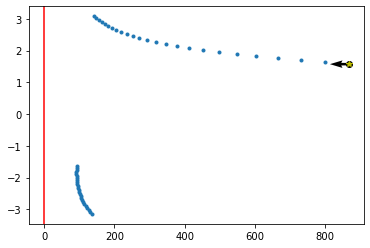

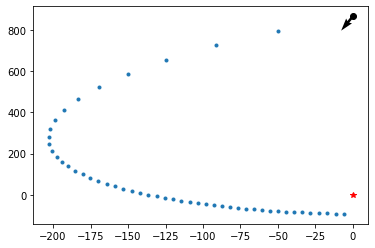

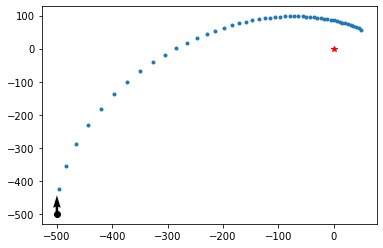

In [95]:
plt.plot(r.value,phi,'.')
plt.plot(r0.value,phi0,'ko')
plt.plot(r.value[0],phi[0],'y*')
plt.quiver(r0.value,phi0,vr0.value,vphi0.value/r0.value)
plt.axvline(x=0,color = 'red')
plt.show()

plt.plot(x2_t,y2_t,'.')
plt.plot(c2[0],c2[1],'ko')
plt.quiver(c2[0],c2[1],v0_v2[0],v0_v2[1])
plt.plot(0,0,'r*')
plt.show()

plt.plot(c1_t[0],c1_t[1],'.')
plt.plot(c1[0],c1[1],'ko')
plt.quiver(c1[0],c1[1],v0_v[0],v0_v[1])
plt.plot(0,0,'r*')
plt.show()

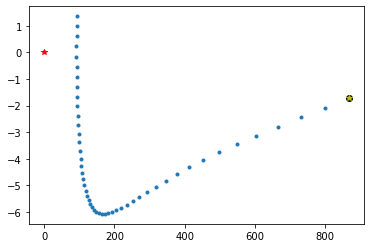

In [96]:
# dt = abs(r0.to(u.km).value/vr0.value)
# plt.plot(r.to(u.km).value,vr.value*dt,'.')
# plt.plot(r0.to(u.km).value,vr0*dt,'ko')
# plt.plot(r.to(u.km).value[0],vr.value[0]*dt,'y*')
# plt.quiver(r0.to(u.km).value,vr0.value*dt,vr0.value*dt,-(const.G*Ms/(r0**2)).value*dt*dt)

plt.plot(r.value,vr.value,'.')
plt.plot(r0.value,vr0,'ko')
plt.plot(r.value[0],vr.value[0],'y*')

plt.plot(0,0,'r*')
plt.show()

In [97]:
for i in range(len(c1_t)):
    x = c1_t[i]
    v = vc1_t[i]
    print(i,(np.sign(np.gradient(x)) == np.sign(v+1e-6)).all())
    if ~(np.sign(np.gradient(x)) == np.sign(v+1e-6)).all():
        print("Sign of position gradients do not match velocities.")

0 True
1 True
2 True


In [98]:
i=1
x = c1_t[i]
v = vc1_t[i]
print(i,(np.sign(np.gradient(x)) == np.sign(v)).all())


1 True


In [92]:
np.sign(np.gradient(x))==np.sign(v+1e-6)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Text(0, 0.5, 'Velocity')

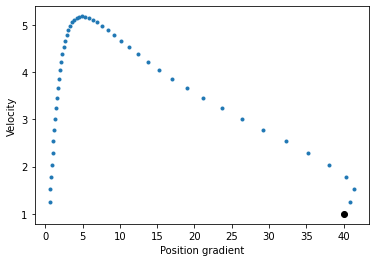

In [61]:
v = vc1_t[2]#.value
x = c1_t[2]#.value
# x = phi#.value#*np.abs(vr.value)
# v = vphi#.value
# x = r.value#*np.abs(vr.value)
# v = vr.value

plt.plot(np.gradient(x),v,'.')
plt.plot(np.gradient(x)[0],v[0],'ko')
# plt.plot([-1000,1000],v[0],'-')
plt.xlabel('Position gradient')
plt.ylabel('Velocity')
# plt.xscale('log')
# plt.show()

/var/folders/1l/xdj2f7v93gb3xgpz1vkqlkk00008j6/T/ipykernel_82577/2716664597.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(v_int/(x-x[0]),'-')


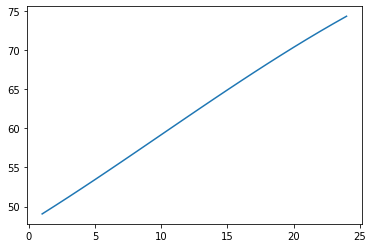

In [642]:
# v = vc1_t[2]#.value
# x = c1_t[2]#.value
x = phi#.value#*np.abs(vr.value)
v = vphi.value
# x = r.value#*np.abs(vr.value)
# v = vr.value

v_int = [np.sum(v[:i]) for i in range(len(v))]
plt.plot(v_int/(x-x[0]),'-')

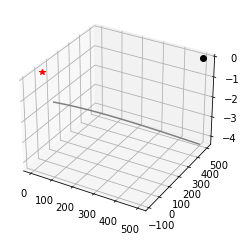

In [598]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x_t = c1_t[0]
y_t = c1_t[1]
z_t = c1_t[2]
ax.plot3D(x_t, y_t, z_t, 'gray')#, marker = 'o')
ax.plot3D(x0,y0,z0, 'ko')
ax.plot3D(0,0,0, 'r*')

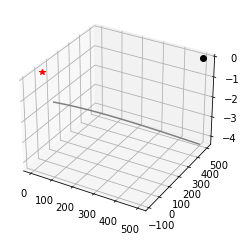

In [599]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x_t = c1_t[0]
y_t = c1_t[1]
z_t = c1_t[2]
ax.plot3D(x_t, y_t, z_t, 'gray')#, marker = 'o')
ax.plot3D(x0,y0,z0, 'ko')
ax.plot3D(0,0,0, 'r*')

In [171]:
v0_v

array([1, 1, 1])

Text(0.5, 0, 'Radial Velocity')

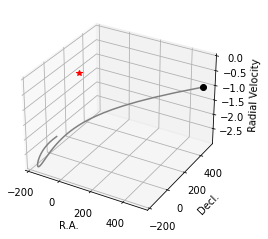

In [130]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x_t = c1_t[0]#[:10]
y_t = c1_t[1]#[:10]
vz_t = vc1_t[2]#[:10]
ax.plot3D(x_t, y_t, vz_t, 'gray')
ax.plot3D(x0, y0, vz0, 'ko')
ax.plot3D(0,0,0, 'r*')
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
ax.set_zlabel('Radial Velocity')
# ax.plot3D(x0,y0,z0, 'ko')
# ax.plot3D(0,0,0, 'r*')

Text(0, 0.5, 'Velocity')

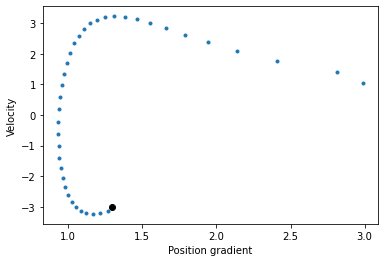

In [15]:
i = 0
plt.plot(np.log10(np.gradient(rt[i])),vt[i],'.')
plt.plot(np.log10(np.gradient(rt[i]))[0],vt[i][0],'ko')
plt.xlabel('Position gradient')
plt.ylabel('Velocity')
# plt.show()

In [60]:
x0 = -500  # R.A.
y0 = -500  # Decl.
z0 = -500  # Radial dist.
vx0 = 0
vy0 = 0
vz0 = 3

Ms_vals = np.logspace(-1,1,11)
rts = []
vts = []
for Ms_val in Ms_vals:
    rt,vt = falling_trajectory(x0,y0,z0,vx0,vy0,vz0,Ms_val,verbose = False)
    rts += [rt]
    vts += [vt]

<IPython.core.display.Javascript object>


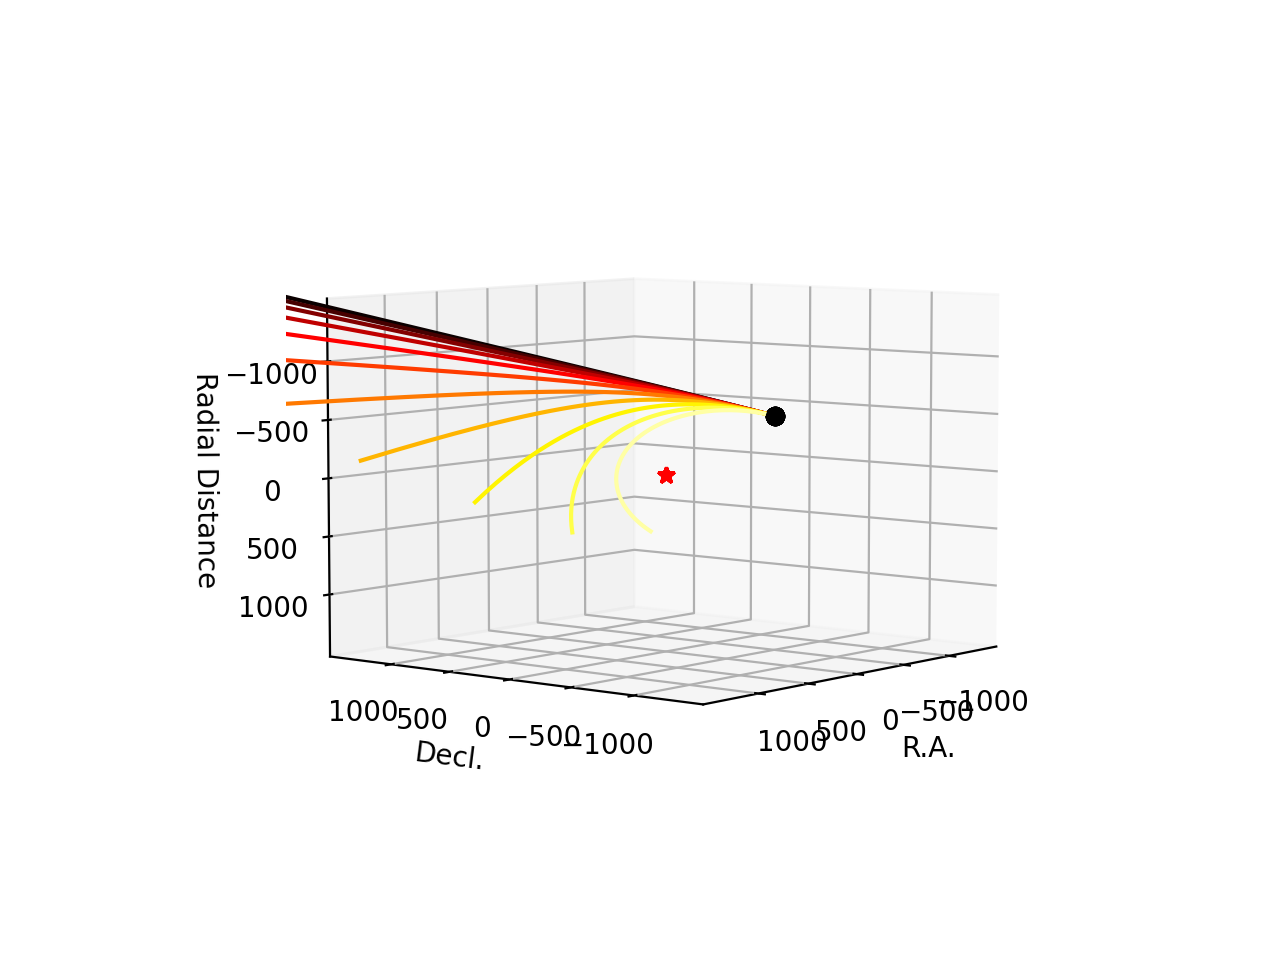

In [61]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(len(Ms_vals)):
    rt = rts[i]
    x_t = rt[0]
    y_t = rt[1]
    z_t = rt[2]
    ax.plot3D(x_t, y_t, z_t, c = cm.hot(range(len(Ms_vals))[i]/len(Ms_vals)))#, marker = 'o')
    ax.plot3D(x0,y0,z0, 'ko')
    ax.plot3D(0,0,0, 'r*')
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
ax.set_zlabel('Radial Distance')
ax.set_xlim(-1000,1000)
ax.set_ylim(-1000,1000)
ax.set_zlim(-1000,1000)
plt.show()


<IPython.core.display.Javascript object>


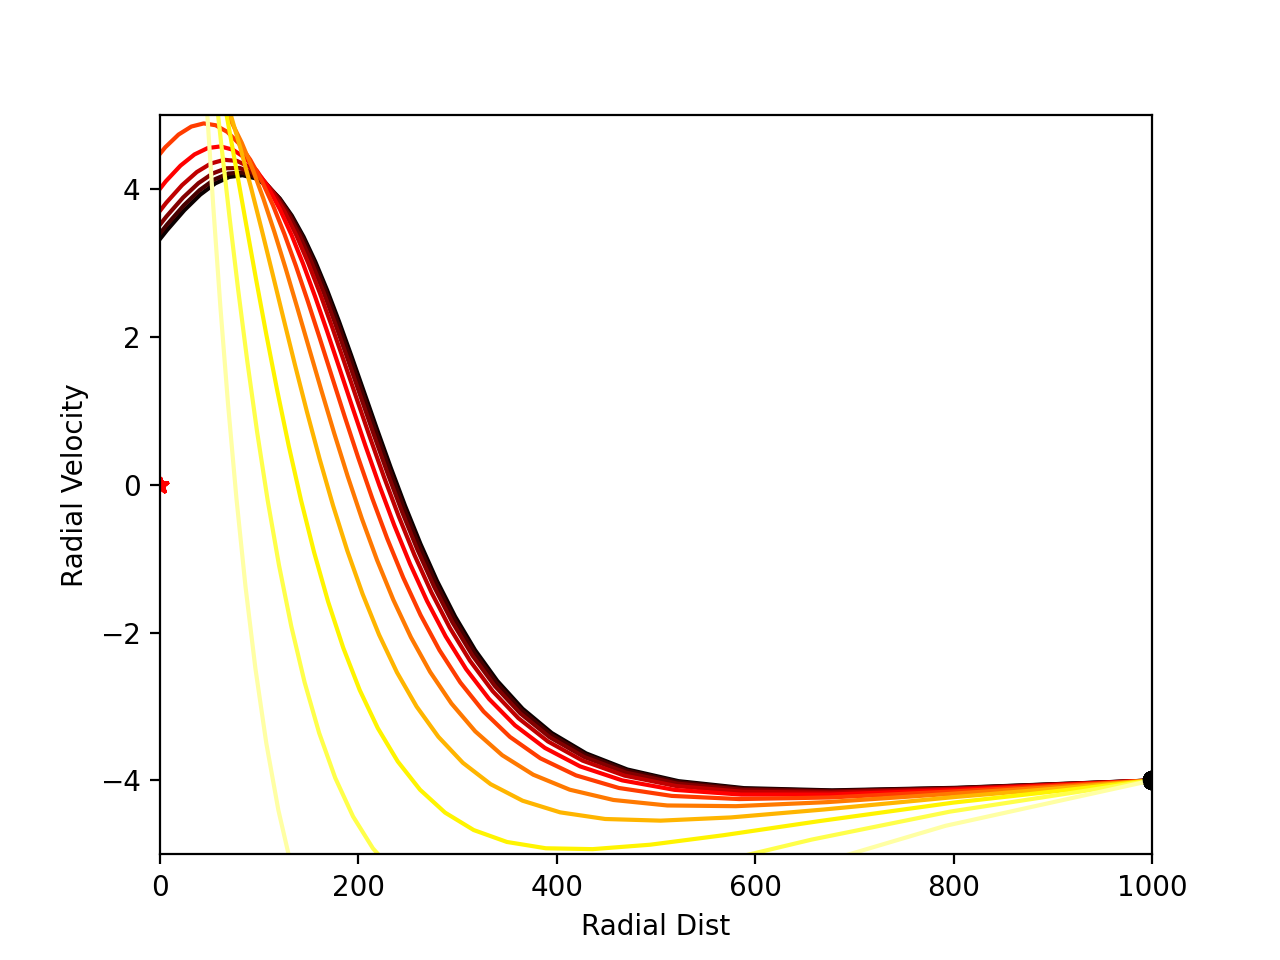

In [58]:
fig = plt.figure()
ax = plt.axes()#projection='3d')
for i in range(len(Ms_vals)):
    rt = rts[i]
    z_t = rt[2]
    vz_t = vts[i][2]
    ax.plot(z_t, vz_t, c = cm.hot(range(len(Ms_vals))[i]/len(Ms_vals)))#, marker = 'o')
    ax.plot(z0,vz0, 'ko')
    ax.plot(0, 'r*')
ax.set_xlabel('Radial Dist')
ax.set_ylabel('Radial Velocity')
ax.set_xlim(0,1000)
ax.set_ylim(-5,5)
plt.show()


<IPython.core.display.Javascript object>


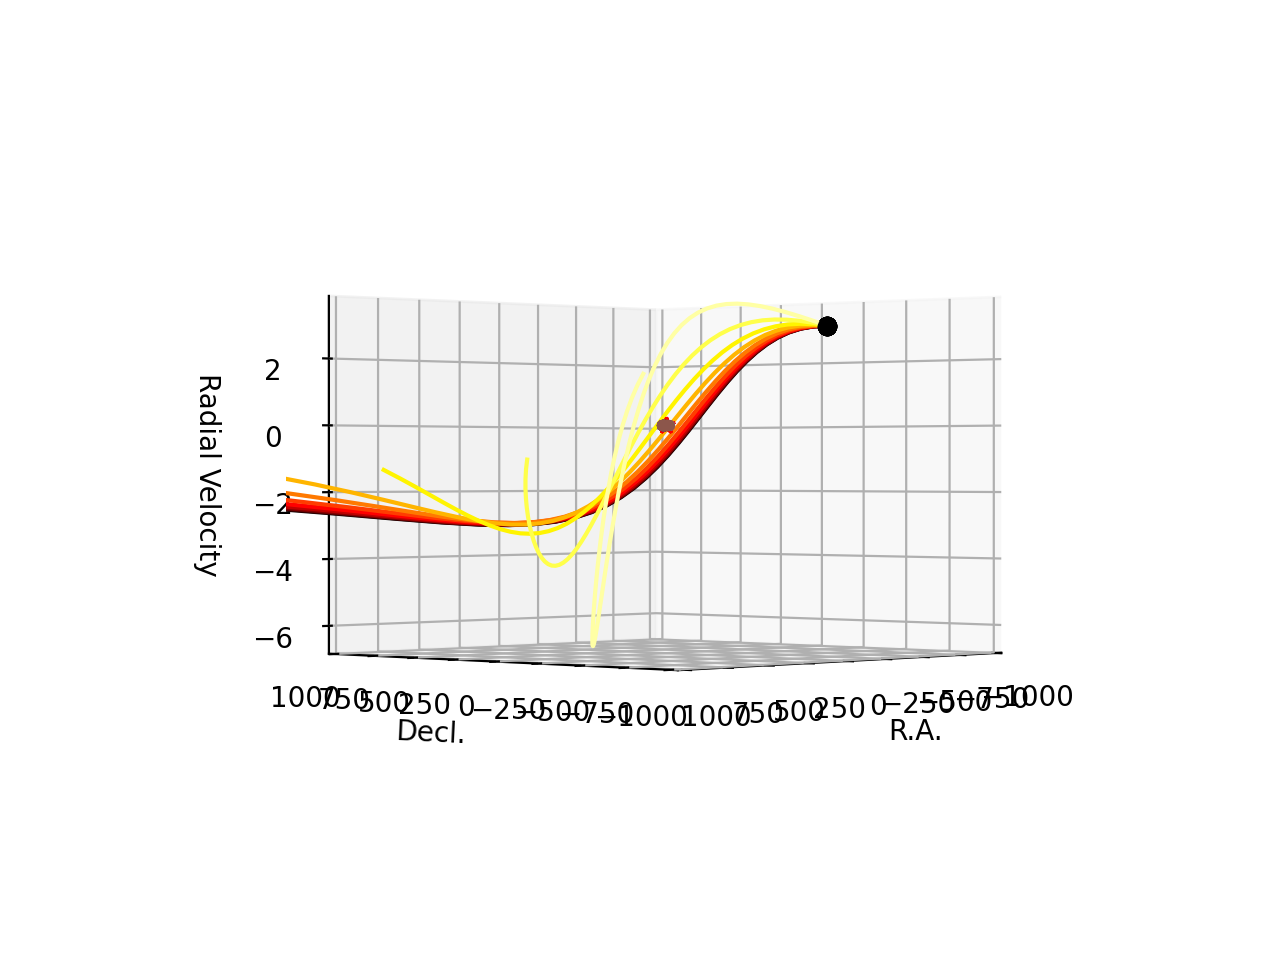

In [63]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(len(Ms_vals)):
    rt = rts[i]
    x_t = rt[0]
    y_t = rt[1]
    vz_t = vts[i][2]
    ax.plot3D(x_t, y_t, vz_t, c = cm.hot(range(len(Ms_vals))[i]/len(Ms_vals)))#, marker = 'o')
    ax.plot3D(x0,y0,vz0, 'ko')
    ax.plot3D(0,0,0, 'r*')
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
ax.set_zlabel('Radial Velocity')
ax.set_xlim(-1000,1000)
ax.set_ylim(-1000,1000)

ax.invert_zaxis()

plt.show()
